In [59]:
from utils import load_data
import pandas as pd
import numpy as np
from scipy import sparse
import implicit
from sklearn.model_selection import train_test_split
from implicit import evaluation
import matplotlib.pyplot as plt

In [60]:
df = load_data("./active1000")
df["time"] = df["time"].apply(
    lambda date: pd.Timestamp(date, unit="s", tz="Europe/Oslo")
)
df.drop(index=df[df.url == "http://adressa.no"].index, inplace=True)


In [61]:
def dataframe_to_user_item_matrix(df):
    df = df.drop_duplicates(subset=['userId', 'documentId'])
    df = df.sort_values(by=['userId', 'time'])

    n_users = df['userId'].nunique()
    n_items = df['documentId'].count()

    ratings = np.zeros((n_users, n_items))

    new_user = df['userId'].values[1:] != df['userId'].values[:-1]
    new_user = np.r_[True, new_user]

    df['uid'] = np.cumsum(new_user)
    item_ids = df['documentId'].unique().tolist()

    new_df = pd.DataFrame({'documentId': item_ids, 'tid': range(1, len(item_ids) + 1)})

    df = pd.merge(df, new_df, on='documentId', how='outer')
    user_id_document_df = df[['documentId', 'uid', 'userId']]
    df_ext = df[['uid', 'tid']]

    users_df = df["uid"].unique()
    user_indexes = set()

    for row in df_ext.itertuples():
        ratings[row[1] - 1, row[2] - 1] = 1.0

        if row[1] in users_df:
            user_indexes.add(row[1] - 1)

    print(f"Matrix created with {ratings.shape[0]} users and {ratings.shape[1]} items")
    return ratings, user_indexes, item_ids, user_id_document_df

user_item_data, user_indexes, item_ids, user_id_document_df = dataframe_to_user_item_matrix(df)

user_item_sparse_matrix = sparse.csr_matrix(user_item_data)
train_data, test_data = train_test_split(user_item_sparse_matrix, random_state=23, test_size=0.25)

Matrix created with 1000 users and 679355 items


In [62]:
'''
fit the model to the training data. factors is set to 50
'''
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(train_data)

100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


In [63]:
'''
Create 50 recommendations for the first user. Outputs tuples of document_ids and the rating in the matrix.
'''
recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=50)
ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
print(list(zip(ids, list(recommendations[1]))))

[('aa6a5862cb2ae9fb8996f35a692192559b9083e1', 0.7734232), ('0a8c6555c75b8fd530be97356c8b62f6a6a4ad83', 0.76179916), ('1ae48cc9bf00e7a94c6fb70e7beb74ee9b926998', 0.7015698), ('cd625da5a4f18ba4912ce7c6a50340b364c2c7f1', 0.70012295), ('0bad5f842d38601fe714f625d46be941fb27f28c', 0.64581335), ('50c3b54c898d2c76681b4e4c02bad53b7a26b01b', 0.62394536), ('7b37701ba1916986c0d63c074df278f9ea9117cb', 0.6158586), ('b85abfb0937cf948a48ca22758a4e03407bc3fcc', 0.59813803), ('ac5205a07fdf4c863910b102fb7e59dc50cbd440', 0.57713586), ('2ba425ed450c17c98bb10837f6ab902dd3e4df6d', 0.5718752), ('794793820080e2f3949a4a8209de055297004031', 0.5716416), ('dd5cc5ad8c5152fb52600d741fc0f6174a93c8bb', 0.56956136), ('01e4d502d724e6206166c33c0ad50a456282124f', 0.5682805), ('313a73912efab2d1be6d24c6a49cf0562e814d59', 0.56605804), ('0867dbb33bb90970ae48592057be34246a0124ac', 0.5654843), ('60a5adfd53e73e44d1fdd9ed07c890879640b2e6', 0.5597323), ('c5662a24bd7ed7754ca53afb4c5a1df6c60ab16b', 0.5570164), ('06b5e4e1e9b702c590db

In [78]:
'''
Function for evaluating recall for a certain user. takes in an array of ids that are recommended and a user index in the matrix.
'''
def evaluate_recall(ids, user_index, max_recommendations):
    user_id = user_id_document_df[user_id_document_df.uid == user_index].iloc[0]['userId']
    true_positive = 0
    total = 0
    current_df = user_id_document_df.drop_duplicates(subset=['documentId', 'userId'])
    mask = current_df.userId.apply(lambda x: x == user_id)
    current_df = current_df[mask]

    docs_recommended_properly = []
    docs_not_recommended_properly = []

    for id in ids:
        try:
            if current_df[current_df.documentId == id].documentId.values[0] == id:
                docs_recommended_properly.append(id)
                true_positive += 1
        except:
            docs_not_recommended_properly.append(id)
        total += 1
    false_negative = current_df.head(max_recommendations).count().uid - true_positive
    #print("Recall: " + str(true_positive / (true_positive + false_negative)) + "\n")
    #print("True positives: " + str(docs_recommended_properly))
    #print("False negatives: " + str(docs_not_recommended_properly))
    return true_positive / (true_positive + false_negative)
evaluate_recall(ids, 1, 50)
    

0.28

In [79]:
'''
Built in mean average precision at k in the implicit library.
'''
evaluation.mean_average_precision_at_k(model, train_data, test_data)

100%|██████████| 250/250 [00:00<00:00, 514.87it/s]


0.29036111111111096

In [80]:
'''
Testing for different recall values on different users with recommendations set to 50
'''
recalls = []
for y in range(0, 100):
    recommendations = model.recommend(y, test_data[y], filter_already_liked_items=True, recalculate_user=True, N=50)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    recalls.append(evaluate_recall(ids, y+1, 50))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))


recalls: [0.28, 0.5, 0.14, 0.34, 0.4, 0.48, 0.3, 0.02, 0.4, 0.3, 0.58, 0.16, 0.52, 0.38, 0.36, 0.46, 0.36, 0.54, 0.42, 0.52, 0.66, 0.62, 0.44, 0.36, 0.24, 0.36, 0.3, 0.16, 0.26, 0.36, 0.62, 0.18, 0.26, 0.32, 0.3, 0.34, 0.22, 0.7, 0.44, 0.38, 0.24, 0.32, 0.54, 0.44, 0.28, 0.4, 0.2, 0.24, 0.62, 0.44, 0.46, 0.2, 0.8, 0.7, 0.54, 0.38, 0.62, 0.3, 0.2, 0.38, 0.44, 0.34, 0.44, 0.42, 0.3, 0.5, 0.54, 0.22, 0.36, 0.36, 0.44, 0.42, 0.36, 0.3, 0.52, 0.52, 0.52, 0.5, 0.6, 0.3, 0.08, 0.4, 0.44, 0.4, 0.36, 0.58, 0.4, 0.4, 0.14, 0.54, 0.66, 0.48, 0.48, 0.52, 0.46, 0.34, 0.3, 0.14, 0.58, 0.12]

average recall: 0.39499999999999985


<BarContainer object of 100 artists>

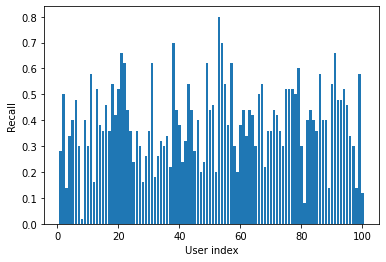

In [81]:
plt.ylabel('Recall')
plt.xlabel('User index')
plt.bar([x for x in range(1, 101)], height=recalls, data=recalls)

In [82]:
'''
Testing for different recall values on different number of recommendations for the same user
'''
recalls = []
for x in range(1, 101):
    recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=x)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    recalls.append(evaluate_recall(ids, 1, x))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))


recalls: [1.0, 0.5, 0.3333333333333333, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.375, 0.3333333333333333, 0.3, 0.36363636363636365, 0.3333333333333333, 0.3076923076923077, 0.2857142857142857, 0.26666666666666666, 0.3125, 0.29411764705882354, 0.2777777777777778, 0.2631578947368421, 0.25, 0.23809523809523808, 0.2727272727272727, 0.2608695652173913, 0.25, 0.28, 0.2692307692307692, 0.25925925925925924, 0.25, 0.2413793103448276, 0.23333333333333334, 0.22580645161290322, 0.21875, 0.24242424242424243, 0.2647058823529412, 0.2857142857142857, 0.3055555555555556, 0.2972972972972973, 0.2894736842105263, 0.28205128205128205, 0.3, 0.2926829268292683, 0.2857142857142857, 0.3023255813953488, 0.29545454545454547, 0.28888888888888886, 0.30434782608695654, 0.2978723404255319, 0.2916666666666667, 0.2857142857142857, 0.28, 0.29411764705882354, 0.28846153846153844, 0.2830188679245283, 0.2777777777777778, 0.2727272727272727, 0.26785714285714285, 0.2631578947368421, 0.25862068965517243, 0.27118644

<BarContainer object of 100 artists>

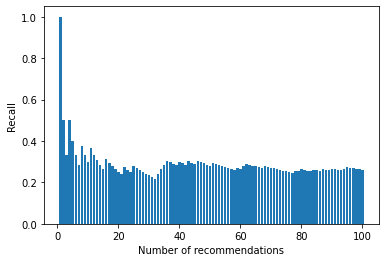

In [83]:
plt.ylabel('Recall')
plt.xlabel('Number of recommendations')
plt.bar([x for x in range(1, 101)], height=recalls, data=recalls)